---
authors: Freek Pols
updated: December 3, 2025
---

# $pV-$ diagram

## Introductie

Wanneer je een gas snel samenperst bij gelijkblijvende volume neemt de temperatuur toe. Wanneer je het gas vervolgens laat ontsnappen, neemt de temperatuur af omdat het gas arbeid verricht. 

We gaan eigenschappen van dit proces bestuderen. In dit practicum ga je een $p-t$-diagram van een brandblusser bestuderen en gebruiken om de specifieke warmte verhouding $\gamma$ te bepalen voor lucht.

## Experiment (60 min)

In dit experiment vullen we een brandblusser met lucht ($P_1, T_1=T_{atm}$). We laten de lucht snel ontsnappen ($P_2=P_{atm}, T_2$), in zo'n korte tijd dat we aannemen dat dit een adiabatisch proces is. Doordat het gas arbeid verricht zal het gas afkoelen. Wanneer we dan, kort na het ontsnappen van de lucht, de kraan weer dicht doen, zal de druk weer toenemen ($P_3,T_3=T_{atm}$). 

In het eerste deel van het proces geldt: 

$$
  T_1^\gamma P_1^{1-\gamma} = T_2^\gamma P_2^{1-\gamma}
$$

ook wel bekend als ... , met $\gamma$ de specifieke warmte verhouding: $\gamma=\frac{C_p}{C_V}$.

Het tweede deel van het proces kan beschreven worden met de wet van Gay-Lussac:

$$ 
  \frac{P_2}{T_2} = \frac{P_3}{T_3}
$$


Onder de aanname dat $T_1 = T_3 = T_{atm}$ volgt hieruit:

$$
 \gamma=\frac{\ln{P_1}-\ln{P_{atm}}}{\ln{P_1}-\ln{P_3}}
$$

```{exercise}
1. Zet de druksensor in het brandblusapparaat, zet de kraan er op en vul de fles met lucht. 
2. Wacht een tijd (~30 min). Waarom?
3. Knijp in de hendel zodat de lucht ontsnapt. Zodra het lucht niet meer ontsnapt, laat de hendel los zodat er geen uitwisseling van lucht meer is.
4. Wacht een korte tijd en haal dan je Arduino en de sd-kaart uit de blusser.
5. Lees de waarden uit in je eigen python script en bepaalde waarde van $\gamma$. Vergelijk deze met de literatuurwaarde ($\gamma = 1.45$)


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import ipywidgets as widgets
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from scipy.optimize import curve_fit
from scipy.stats import norm
from matplotlib.widgets import Slider
from ipywidgets import interact
from ipywidgets import interact, widgets


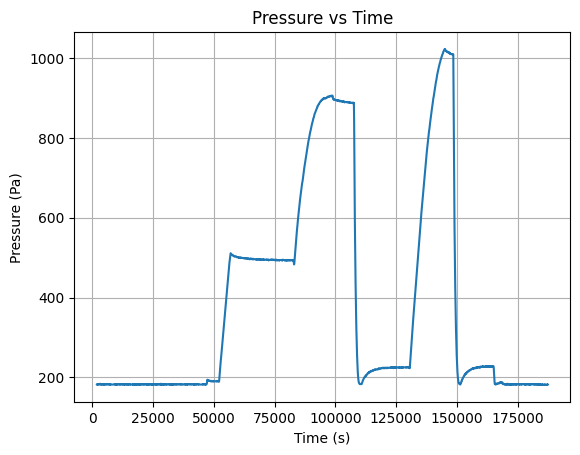

In [17]:
data = np.loadtxt(r"C:\Users\simon\Downloads\TU Delft\Bsc1 TN\Q2\IP2\Labs\data (1).csv", delimiter=",", skiprows=1)
time = data[:,0]
pressure = data[:,1]
plt.plot(time, pressure)
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure vs Time")
plt.grid()
plt.show()

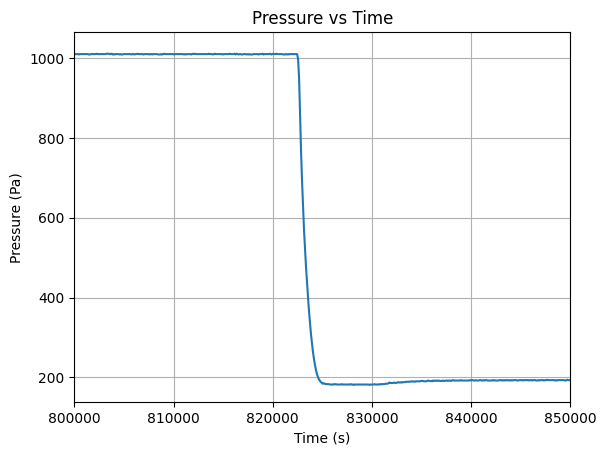

In [18]:
data_2 = np.loadtxt(r"C:\Users\simon\Downloads\TU Delft\Bsc1 TN\Q2\IP2\Labs\DATA_brandblusser_2.csv", delimiter=",", skiprows=1, unpack=True)
time_2 = data_2[0,:]
pressure_2 = data_2[1,:]
plt.figure()
plt.plot(time_2, pressure_2)
plt.xlabel("Time (s)")
plt.xlim(0.8*1e6, 0.85*1e6)
plt.ylabel("Pressure (Pa)")
plt.title("Pressure vs Time")
plt.grid()
plt.show()


In [20]:
#druk omrekenen naar Pa
#182 = 1 atm = 101325 Pa
#222 = 2 atm = 202650 Pa

pressure_Pa = (pressure - 182) * (101325 / (222 - 182))

In [ ]:
# Data inladen
data_2 = np.loadtxt(r"C:\Users\simon\Downloads\TU Delft\Bsc1 TN\Q2\IP2\Labs\DATA_brandblusser_2.csv", delimiter=",", skiprows=1, unpack=True)
time_2 = data_2[0,:]
pressure_2 = data_2[1,:]

# Functie om de plot bij te werken op basis van geselecteerde druk
def plot_pressure(p):
    plt.figure(figsize=(8,5))
    plt.plot(time_2, pressure_2, label="Pressure vs Time")
    
    #Index van de dichtstbijzijnde drukwaarde vinden
    idx = np.abs(pressure_2 - p).argmin()
    t_closest = time_2[idx]
    p_closest = pressure_2[idx]
    
    #Een marker en lijn toevoegen op geselecteerde plek
    plt.axhline(p_closest, color='red', linestyle='--', label=f"Selected Pressure: {p_closest:.2f}")
    plt.axvline(t_closest, color='blue', linestyle='--', label=f"Corresponding Time: {t_closest:.2f}")
    plt.scatter(t_closest, p_closest, color='black', zorder=5)
    
    plt.xlabel("Time")
    plt.ylabel("Pressure")
    plt.title("Pressure vs Time (Interactive)")
    plt.grid(True)
    plt.legend()
    
#Slider voor de drukwaarde
interact(plot_pressure, 
         p=widgets.FloatSlider(min=np.min(pressure_2), 
                                max=np.max(pressure_2), 
                                step=0.1, 
                                value=np.mean(pressure_2),
                                description="Pressure"))

interactive(children=(FloatSlider(value=736.9663985252221, description='Pressure', max=1023.0, min=181.0), Out…

<function __main__.plot_pressure(p)>

## Arduino

Gebruikte arduino code, heb je verder niet nodig.

```{code} C++
#include <SPI.h>
#include <SD.h>

const int drukpin = A1;
const int CS_PIN  = SDCARD_SS_PIN;

const uint32_t SAMPLE_MS = 100;   // log-interval
const char* FNAME = "DATA.CSV";

void blink(uint8_t times, uint16_t onMs, uint16_t offMs, uint16_t pauseMs) {
  for (uint8_t i = 0; i < times; i++) {
    digitalWrite(LED_BUILTIN, HIGH);
    delay(onMs);
    digitalWrite(LED_BUILTIN, LOW);
    delay(offMs);
  }
  delay(pauseMs);
}

void fatalSd() {
  while (1) blink(3, 100, 100, 600);   // 3 snelle
}

void fatalFile() {
  while (1) blink(2, 250, 250, 800);   // 2 langzame
}

void setup() {
  pinMode(LED_BUILTIN, OUTPUT);
  digitalWrite(LED_BUILTIN, LOW);

  pinMode(drukpin, INPUT);

  // Geef voeding + SD wat tijd op batterij
  delay(800);

  // SD init met retries (zonder Serial kun je anders niks zien)
  bool ok = false;
  for (int attempt = 0; attempt < 5; attempt++) {
    if (SD.begin(CS_PIN)) { ok = true; break; }
    blink(1, 50, 50, 200);   // klein "ik probeer" knipje
    delay(300);
  }
  if (!ok) fatalSd();

  // Bestand aanmaken + header schrijven (1x), dan sluiten
  File f = SD.open(FNAME, FILE_WRITE);
  if (!f) fatalFile();

  // Als bestand leeg is, header toevoegen
  if (f.size() == 0) {
    f.println("time_ms,value");
  }
  f.close();

  // korte bevestiging
  blink(5, 60, 60, 300);
}

void loop() {
  static uint32_t last = 0;
  uint32_t now = millis();
  if (now - last < SAMPLE_MS) return;
  last = now;

  int value = analogRead(drukpin);

  File f = SD.open(FNAME, FILE_WRITE);
  if (!f) fatalFile();

  f.print(now);
  f.print(',');
  f.println(value);
  f.close();                 // <- belangrijk: file echt wegschrijven

  // schrijf-indicatie
  digitalWrite(LED_BUILTIN, HIGH);
  delay(10);
  digitalWrite(LED_BUILTIN, LOW);
}
```